# 30. 층수에 따른 가격 이상치 탐지
- 대부분 층수가 높아지면 가격이 상승한다.
- 지하2층, 65층의 경우 형상이 조금 다르다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import gc
from sklearn.preprocessing import MinMaxScaler

# 맥에서 글씨 깨짐 방지
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('../data/preprocessed/29_2_area_target_outlier.csv')

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_3984/2352522197.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/preprocessed/29_2_area_target_outlier.csv')


In [4]:
df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128090,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128091,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128092,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0


In [5]:
train_df = df[df['is_test']==0]
test_df = df[df['is_test']==1]

In [6]:
tmp = pd.DataFrame(train_df.groupby('층')['target'].mean())
tmp.reset_index(inplace=True)
tmp

,층,target
0,-4,61454.250000
1,-3,66876.200000
2,-2,199159.838710
3,-1,75713.920035
4,1,53406.719177
...,...,...
68,65,147660.000000
69,66,265531.250000
70,67,246083.333333
71,68,200208.333333


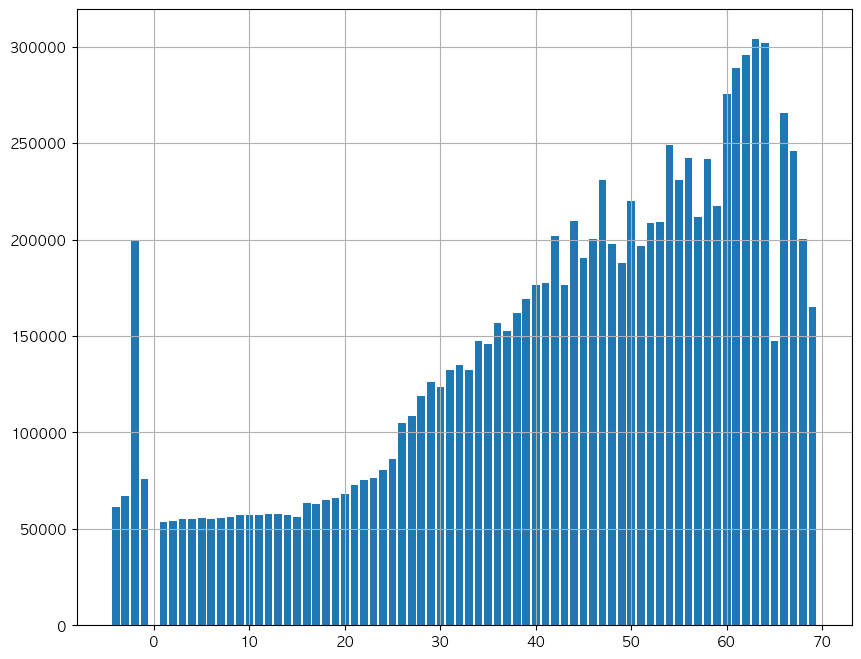

In [7]:
plt.figure(figsize=(10, 8))
plt.bar(tmp['층'], tmp['target'])
plt.grid(True)
plt.show()

In [8]:
# 이상치로 판단하여 제거가 필요한 인덱스 저장 리스트
need_drop = []

## 지하 2층
- 가격이 급격히 커진다.
- '한남더힐'의 가격이 압도적이기 때문
- test_df에도 '한남더힐'존재 -> 지하2층은 없고 지하 1층만 존재
- '한남더힐' 중 지하2층 데이터 제거

In [9]:
tmp = train_df[train_df['층']==-2][['아파트명', '좌표Y', '좌표X', '층', '전용면적', '계약년월', 'target']]
tmp.reset_index(inplace=True)
tmp

,index,아파트명,좌표Y,좌표X,층,전용면적,계약년월,target
0,26438,천왕연지타운1단지,37.477355,126.837665,-2,84.9500,201805,56500.0
1,87307,한남더힐,37.536978,127.009496,-2,240.2300,201804,600000.0
2,87322,한남더힐,37.536978,127.009496,-2,240.3050,201806,620000.0
3,91163,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,134.4800,201801,60000.0
4,91188,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,134.4800,201808,76000.0
5,216500,옥수파크힐스101동~116동,37.548477,127.013995,-2,107.9900,202305,290000.0
6,321334,천왕연지타운2단지,37.482919,126.844790,-2,84.7800,202007,67700.0
7,359292,옥수파크힐스101동~116동,37.548477,127.013995,-2,76.6600,202006,167500.0
8,359304,옥수파크힐스101동~116동,37.548477,127.013995,-2,107.9900,202007,220000.0
9,361709,롯데캐슬골든힐스,37.608918,127.015960,-2,59.8946,202006,74500.0


In [10]:
tmp.sort_values('계약년월', inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp

,index,아파트명,좌표Y,좌표X,층,전용면적,계약년월,target
0,1115466,옥인시민,37.582600,126.963645,-2,59.5000,200707,28000.0
1,964897,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,134.6600,201108,65919.0
2,904805,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,134.7100,201211,62403.0
3,904804,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,134.5100,201211,58169.0
4,785791,천왕연지타운2단지,37.482919,126.844790,-2,84.7800,201403,37000.0
5,755311,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,134.5100,201411,55797.0
6,755308,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,167.7500,201411,76533.0
7,755318,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,134.5100,201501,55181.0
8,755326,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,134.5100,201503,56472.0
9,640349,우물골2단지두산위브BL2-7,37.636440,126.928783,-2,167.7500,201512,74466.0


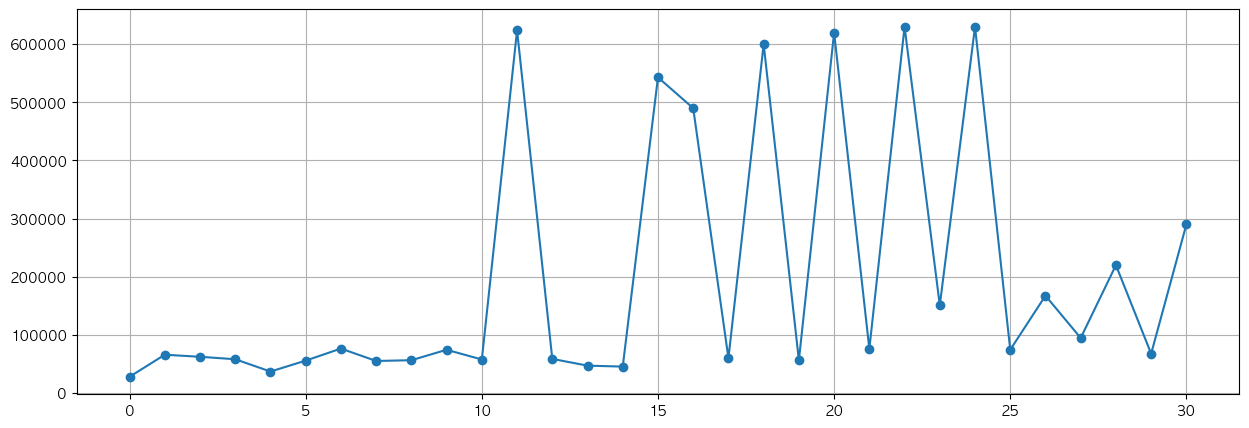

In [11]:
plt.figure(figsize=(15, 5))
tmp['target'].plot(marker='o')
plt.grid(True)
plt.show()

In [12]:
test_df[test_df['아파트명']=='한남더힐'][['층']]

,층
1127103,8
1127104,2
1127105,2
1127106,5
1127107,-1


In [13]:
need_drop.extend([635919, 534725, 534774, 87307, 87322, 436831, 436888])

In [14]:
need_drop

[635919, 534725, 534774, 87307, 87322, 436831, 436888]

## 65층

In [15]:
tmp = train_df[train_df['층']==65][['아파트명', '좌표Y', '좌표X', '층', '전용면적', '계약년월', 'target']]
tmp.reset_index(inplace=True)
tmp

,index,아파트명,좌표Y,좌표X,층,전용면적,계약년월,target
0,78489,현대하이페리온,37.526854,126.875035,65,154.05,201804,171000.0
1,432534,현대하이페리온,37.526854,126.875035,65,138.20,201908,175000.0
2,626923,현대하이페리온,37.526854,126.875035,65,138.20,201604,117300.0
3,741029,현대하이페리온,37.526854,126.875035,65,154.05,201509,139000.0
4,998482,현대하이페리온,37.526854,126.875035,65,138.20,201002,136000.0


In [16]:
tmp.sort_values('계약년월', inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp

,index,아파트명,좌표Y,좌표X,층,전용면적,계약년월,target
0,998482,현대하이페리온,37.526854,126.875035,65,138.20,201002,136000.0
1,741029,현대하이페리온,37.526854,126.875035,65,154.05,201509,139000.0
2,626923,현대하이페리온,37.526854,126.875035,65,138.20,201604,117300.0
3,78489,현대하이페리온,37.526854,126.875035,65,154.05,201804,171000.0
4,432534,현대하이페리온,37.526854,126.875035,65,138.20,201908,175000.0


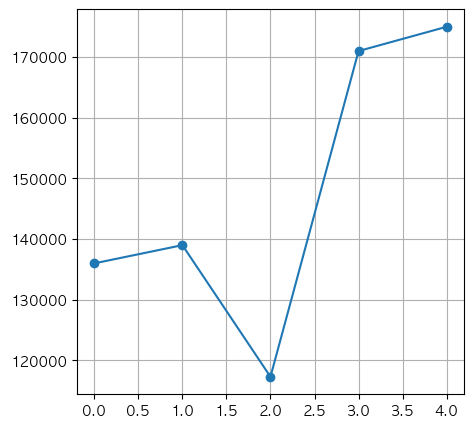

In [17]:
plt.figure(figsize=(5, 5))
tmp['target'].plot(marker='o')
plt.grid(True)
plt.show()

In [18]:
need_drop.append(626923)

## 69층

In [88]:
tmp = train_df[train_df['층']==69][['아파트명', '좌표Y', '좌표X', '층', '전용면적', '계약년월', 'target']]
tmp.reset_index(inplace=True)
tmp

,index,아파트명,좌표Y,좌표X,층,전용면적,계약년월,target
0,78510,현대하이페리온,37.526854,126.875035,69,167.44,201809,183000.0
1,741018,현대하이페리온,37.526854,126.875035,69,154.05,201502,147000.0


# 원본에 적용
- 이상치로 판단한 데이터 drop

In [19]:
df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128090,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128091,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128092,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0


In [20]:
train_df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0


In [21]:
print(len(need_drop))
train_df.drop(need_drop, inplace=True)
train_df

8


/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_3984/30688504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(need_drop, inplace=True)


,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0


In [22]:
train_df.reset_index(drop=True, inplace=True)
train_df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118809,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118810,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118811,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118812,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0


In [23]:
re = pd.concat([train_df, test_df], axis=0)
re

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128090,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128091,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128092,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0


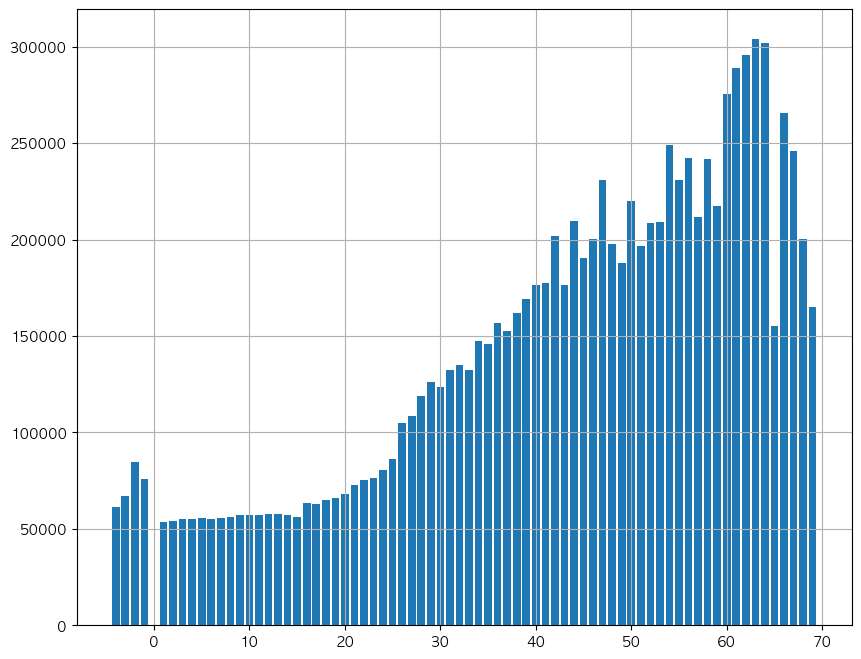

In [25]:
train_df = re[re['is_test']==0]

tmp = pd.DataFrame(train_df.groupby('층')['target'].mean())
tmp.reset_index(inplace=True)
tmp

plt.figure(figsize=(10, 8))
plt.bar(tmp['층'], tmp['target'])
plt.grid(True)
plt.show()

In [26]:
re.to_csv('../data/preprocessed/30_2_floor_target_outlier.csv', index=False)